In [1]:
from poloniex import Poloniex
from tusp import string2ts, ts2string
import json
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

polo = Poloniex()

# historyData es una lista de diccionarios python
# candlestick period in seconds; valid values are 300, 900, 1800, 7200, 14400, and 86400
historyData = polo.returnChartData(currencyPair="BTC_DGB",
                     start=string2ts("2017-03-01 00:00:00"),
                     end=string2ts("2017-09-01 0:00:00"),
                     period=3600*4)

# Guardando los datos como lista de diccionarios en un archivo de texto
# esto permite acceder a ellos y trabajar como data frame offline
with open("XMR_data.out","w") as f:
    json.dump(historyData,f)
    
with open("XMR_data.out") as f:
    historyData = json.load(f)
    #print data

# convirtiendo datos en data frame
df = pd.DataFrame(historyData)

#  convirtiendo string a float o int
df["close"] =pd.to_numeric(df['close'])
df["open"] =pd.to_numeric(df['open'])
df["low"] =pd.to_numeric(df['high'])
df["volume"] =pd.to_numeric(df['volume'])
df["date"] = pd.to_datetime(df["date"].apply(ts2string))
df["weightedAverage"] =pd.to_numeric(df['weightedAverage'])

# seleccionando la columna de fecha como indice
df = df.set_index("date")

# examinando las primeras filas
df.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-03-01 03:00:00,2.200000e-07,2.3e-7,2.300000e-07,2.100000e-07,18770122.693472,4.128088,2.100000e-07
2017-03-01 07:00:00,2.200000e-07,2.3e-7,2.300000e-07,2.200000e-07,22229479.359008,4.863374,2.100000e-07
2017-03-01 11:00:00,2.100000e-07,2.2e-7,2.200000e-07,2.100000e-07,28364432.262056,6.000823,2.100000e-07
2017-03-01 15:00:00,2.000000e-07,2.2e-7,2.200000e-07,2.100000e-07,56868335.178277,11.441864,2.000000e-07
2017-03-01 19:00:00,1.900000e-07,2.0e-7,2.000000e-07,2.000000e-07,3592812.1474852,0.687369,1.900000e-07


# Calculando retornos, log retornos y sus respectivos acumulados

Retorno final del mercado: 1709.09090909


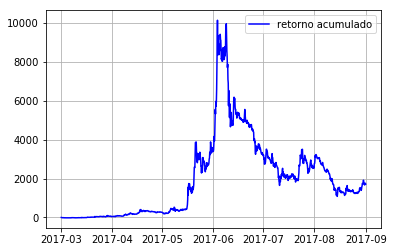

In [2]:
# Calculando retornos relativos
# el 1 se refiere al numero de periodos que se toma para calcular el cambio porcentual
df["retornos relativos"] = df["close"].pct_change(1).fillna(0)

# calculando los log retornos
df["log retornos"] = np.log(df["close"]).diff().fillna(0)

# calculando log retorno acumulado
df["cum_logr"] = df["log retornos"].cumsum()
df["cum_r"] = np.exp(df["cum_logr"]) - 1

#plt.plot(df.index,df['cum_logr']*100,'r',label='log retorno acumulado')
plt.plot(df.index,df['cum_r']*100,'b', label='retorno acumulado')
plt.legend()
plt.grid()
#df.isnull().any()
#df[df['retornos relativos'].isnull()]
print "Retorno final del mercado: %s"%(df["cum_r"][-1]*100)

# Ejemplo estrategía, media movil

Las estrategías funcionan como funciones que como parámetro reciben una serie de pandas o una lista de tamaño $T$ (intervalo de tiempo de estudio divido en el periodo de interés), y devuelven el vector de pesos $\vec{w}$ de tamaño $T\times 2$ y que contiene solo ceros o unos (1 si se posee el determinado activo, 0 si no). La primera columna de $\vec{w}$ corresponde a la posesión del activo de interés, la segunda a la posesión de la moneda por la que se tranza (generalmente **BTC**) 

El retorno con la estrategia EMA_5 vs SMA_20 fue 998.161728829


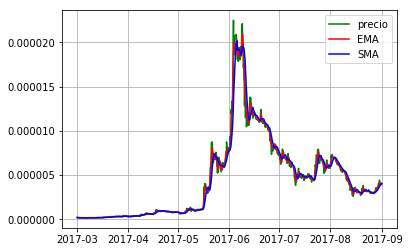

In [3]:
from profit import profit,change5, profit2
from orders import orders

# dada una serie de pandas o una lista y el numero de muestras para la EMA y SMA devuelve vector w
# considerando el cruce entre EMA y SMA
def estrategiaEMAvsSMA(serie, smaPeriod=13,emaPeriod=5):
    
    # Calculando media movil a 20 muestras
    sma = serie.rolling(smaPeriod,min_periods=1).mean()
    # caculando exponential movil average
    ema = serie.ewm(span=emaPeriod, adjust=False).mean()
    
    # Encontrando el signo de la resta entre ellas para encontrar los cruces
    dif = (ema - sma).apply(np.sign)
    
    w = pd.DataFrame(data={"w":(dif+1)/2})
    
    w['w'] = w['w'].apply(change5)
    
    w["orders"] = orders(w["w"])
    w['w'] = w['w'].shift(1)
    w["price"] = serie
    
    plt.plot(df.index[:],df['close'][:],'g',label='precio')
    plt.plot(df.index[:],ema[:],'r',label='EMA')
    plt.plot(df.index[:],sma[:],'b',label='SMA')
    plt.legend(loc='best')
    plt.grid()
    
    return w



w = estrategiaEMAvsSMA(df['weightedAverage'])
relativeReturn, vecReturn = profit(w)

#relativeReturn2, vecReturn2 = profit2(w,1.0)

print 'El retorno con la estrategia EMA_5 vs SMA_20 fue %s'%(vecReturn[-1]*100)

w["return1"] = vecReturn
#print w.loc["2017-06-01 03:00:00":"2017-06-02 07:00:00",["orders","price","btc_balance","coin_balance","balance"]]
#print w[w["orders"]!="WAIT"][["orders","balance","btc_balance","coin_balance","price"]][:15]
#print w[["orders","w","return1","price"]][:15]

In [4]:
from strategy import pricevsEMA, pricevsSMA, EMAvsEMA

#Precio vs EMA_5
# 23.6
w = pricevsEMA(df['weightedAverage'],5)
relativeReturn,v = profit(w)

#Precio vs SMA_20

w2 = pricevsSMA(df['weightedAverage'])
relativeReturn2,v2 = profit(w2)

print 'El retorno relativo con la estrategia precio VS SMA20 fue: %s'%(relativeReturn2*100)
print 'El retorno relativo con la estrategia Precio VS EMA5 fue: %s'%(relativeReturn*100)

El retorno relativo con la estrategia precio VS SMA20 fue: 2474.30942518
El retorno relativo con la estrategia Precio VS EMA5 fue: 5611.08474574


Graficand los retornos de un par de estrategías y el comportamiento del precio

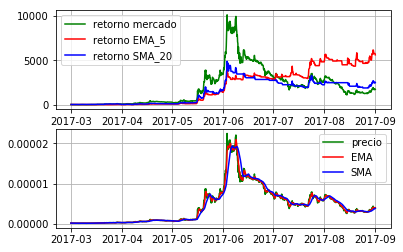

In [5]:
# Calculando media movil a 20 muestras
sma = df["close"].rolling(20,min_periods=1).mean()
# caculando exponential movil average
ema = df["close"].ewm(span=5, adjust=False).mean()

plt.subplot(211)
plt.plot(df.index,df['cum_r']*100,'g', label='retorno mercado')
plt.plot(df.index,v*100,'r',label='retorno EMA_5')
plt.plot(df.index,v2*100,'b',label='retorno SMA_20')
plt.legend(loc='best')
plt.grid()

plt.subplot(212)
plt.plot(df.index,df['close'],'g',label='precio')
plt.plot(df.index,ema,'r',label='EMA')
plt.plot(df.index,sma,'b',label='SMA')
plt.legend(loc='best')
plt.grid()

# Agregando RSI via Stockstacks

En primera instancia, la idea es calcular el RSI y utilizarlo para mejorar la estrategia de las medias móviles. 

/home/daniel/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,close,high,low,open,quotevolume,volume,weightedaverage,retornos relativos,log retornos,cum_logr,cum_r,close_-1_s,close_-1_d,rs_14,rsi_14
date,,,,,,,,,,,,,,,
2017-03-01 03:00:00,2.200000e-07,2.3e-7,2.300000e-07,2.100000e-07,18770122.693472,4.128088,2.100000e-07,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2017-03-01 07:00:00,2.200000e-07,2.3e-7,2.300000e-07,2.200000e-07,22229479.359008,4.863374,2.100000e-07,0.000000,0.000000,0.000000,0.000000,2.200000e-07,0.000000e+00,NaN,NaN
2017-03-01 11:00:00,2.100000e-07,2.2e-7,2.200000e-07,2.100000e-07,28364432.262056,6.000823,2.100000e-07,-0.045455,-0.046520,-0.046520,-0.045455,2.200000e-07,-1.000000e-08,0.0,0.0
2017-03-01 15:00:00,2.000000e-07,2.2e-7,2.200000e-07,2.100000e-07,56868335.178277,11.441864,2.000000e-07,-0.047619,-0.048790,-0.095310,-0.090909,2.100000e-07,-1.000000e-08,0.0,0.0
2017-03-01 19:00:00,1.900000e-07,2.0e-7,2.000000e-07,2.000000e-07,3592812.1474852,0.687369,1.900000e-07,-0.050000,-0.051293,-0.146603,-0.136364,2.000000e-07,-1.000000e-08,0.0,0.0


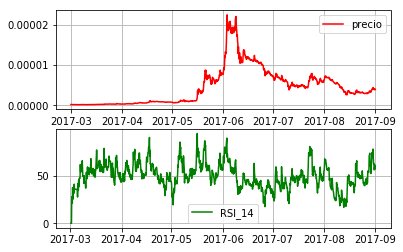

In [6]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())

stock["rsi_14"]

plt.subplot(211)
plt.plot(df.index,df['close'],'r', label='precio')
plt.legend(loc='best')
plt.grid()

plt.subplot(212)
plt.plot(df.index,stock["rsi_14"],'g',label='RSI_14')
plt.legend(loc='best')
plt.grid()

stock.head()

# Calculando maximos y minimos, generando vector w con estos.